In [6]:
import pandas as pd

# Load ECG signal
csv_path = "dataset/100.csv"
df = pd.read_csv(csv_path)

# Clean up column names
df.columns = df.columns.str.strip().str.replace("'", "")
ecg_signal = df['MLII'].dropna().values  # Select MLII lead

print(f"ECG signal loaded: {len(ecg_signal)} samples")

ECG signal loaded: 650000 samples


In [7]:
# Load annotations
annotations_path = "dataset/100annotations.txt"
with open(annotations_path, 'r') as f:
    lines = f.readlines()

# Skip the header line
lines = lines[1:]

# Parse relevant data (Sample # and Type)
annotation_data = []
for line in lines:
    parts = line.strip().split()
    if len(parts) >= 3:
        sample = int(parts[1])
        label = parts[2]
        annotation_data.append((sample, label))

# Convert to DataFrame
ann_df = pd.DataFrame(annotation_data, columns=["Sample", "Type"])
print(ann_df.head())

   Sample Type
0      18    +
1      77    N
2     370    N
3     662    N
4     946    N


In [8]:
import os
import pandas as pd
import numpy as np

# === CONFIG ===
DATASET_FOLDER = r"dataset"
OUTPUT_FOLDER = r"labeled_beats"
fs = 360  # Sampling rate
pre = int(0.2 * fs)
post = int(0.4 * fs)

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# === FUNCTION TO PROCESS EACH RECORD ===
def process_record(record_id):
    csv_path = os.path.join(DATASET_FOLDER, f"{record_id}.csv")
    annotation_path = os.path.join(DATASET_FOLDER, f"{record_id}annotations.txt")

    # Check if both files exist
    if not os.path.exists(csv_path) or not os.path.exists(annotation_path):
        print(f"Missing files for record {record_id}")
        return

    # Load ECG
    df_ecg = pd.read_csv(csv_path)
    df_ecg.columns = df_ecg.columns.str.strip().str.replace("'", "")
    if 'MLII' not in df_ecg.columns:
        print(f"MLII column not found in record {record_id}")
        return
    ecg_signal = df_ecg['MLII'].dropna().values

    # Load annotations
    with open(annotation_path, 'r') as f:
        lines = f.readlines()[1:]  # skip header
    annotation_data = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) >= 3:
            try:
                sample = int(parts[1])
                label = parts[2]
                annotation_data.append((sample, label))
            except ValueError:
                continue
    ann_df = pd.DataFrame(annotation_data, columns=["Sample", "Type"])

    # Extract beat segments
    segments, labels = [], []
    for _, row in ann_df.iterrows():
        idx = row["Sample"]
        label = row["Type"]
        if label in ['+', '/', '!', '[', ']', '|', '~', '=', 'x']:
            continue
        start = idx - pre
        end = idx + post
        if start >= 0 and end <= len(ecg_signal):
            beat = ecg_signal[start:end]
            if len(beat) == pre + post:
                segments.append(beat)
                labels.append(label)

    if len(segments) == 0:
        print(f"No valid beats extracted for {record_id}")
        return

    df_out = pd.DataFrame(segments)
    df_out["Label"] = labels
    out_path = os.path.join(OUTPUT_FOLDER, f"labeled_beats_{record_id}.csv")
    df_out.to_csv(out_path, index=False)
    print(f"Processed record {record_id}: {len(segments)} beats saved.")

# === RUN LOOP ===
for rec in range(100, 235):
    process_record(str(rec))


Processed record 100: 2272 beats saved.
Processed record 101: 1865 beats saved.
MLII column not found in record 102
Processed record 103: 2083 beats saved.
MLII column not found in record 104
Processed record 105: 2572 beats saved.
Processed record 106: 2027 beats saved.
Processed record 107: 59 beats saved.
Processed record 108: 1763 beats saved.
Processed record 109: 2531 beats saved.
Missing files for record 110
Processed record 111: 2124 beats saved.
Processed record 112: 2538 beats saved.
Processed record 113: 1794 beats saved.
Processed record 114: 1879 beats saved.
Processed record 115: 1952 beats saved.
Processed record 116: 2411 beats saved.
Processed record 117: 1534 beats saved.
Processed record 118: 2277 beats saved.
Processed record 119: 1987 beats saved.
Missing files for record 120
Processed record 121: 1862 beats saved.
Processed record 122: 2475 beats saved.
Processed record 123: 1517 beats saved.
Processed record 124: 1618 beats saved.
Missing files for record 125
Mis

In [9]:
import os
import pandas as pd

# Folder containing all labeled beat CSVs
folder_path = r"labeled_beats"

# List to collect each CSV's DataFrame
all_data = []

# Loop through all CSV files in the folder
for file in os.listdir(folder_path):
    if file.startswith("labeled_beats_") and file.endswith(".csv"):
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        df["Record"] = file.split("_")[-1].replace(".csv", "")  # Optional: keep track of source
        all_data.append(df)

# Merge all into one DataFrame
merged_df = pd.concat(all_data, ignore_index=True)

# Save to a single CSV
merged_df.to_csv("merged_labeled_beats.csv", index=False)

print(f"Merged {len(all_data)} files into merged_labeled_beats.csv")
print(f"Total beats: {merged_df.shape[0]}, Features per beat: {merged_df.shape[1]-2}")


Merged 46 files into merged_labeled_beats.csv
Total beats: 101862, Features per beat: 216


Wavelet Transform Denoising

In [10]:
import pywt
import numpy as np

def wavelet_denoise(signal, wavelet='db6', level=4, threshold_method='soft'):
    # Decompose the signal into wavelet coefficients
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    
    # Estimate a universal threshold using the noise estimate from the first detail coefficients
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))

    # Apply thresholding to detail coefficients
    denoised_coeffs = [coeffs[0]]  # Keep approximation coefficients untouched
    for detail in coeffs[1:]:
        denoised_detail = pywt.threshold(detail, value=uthresh, mode=threshold_method)
        denoised_coeffs.append(denoised_detail)

    # Reconstruct the signal from denoised coefficients
    denoised_signal = pywt.waverec(denoised_coeffs, wavelet)
    
    # Trim or pad to original length
    return denoised_signal[:len(signal)]

In [11]:
import pandas as pd

# Load your merged labeled beats
df = pd.read_csv("merged_labeled_beats.csv")

# Apply denoising to each beat
beat_columns = df.columns.difference(['Label', 'Record'])  # All signal columns
beat_matrix = df[beat_columns].values

denoised_beats = []
for beat in beat_matrix:
    denoised = wavelet_denoise(beat)
    denoised_beats.append(denoised)

# Create new DataFrame with denoised beats
denoised_df = pd.DataFrame(denoised_beats, columns=beat_columns)
denoised_df["Label"] = df["Label"].values
denoised_df["Record"] = df["Record"].values

# Save
denoised_df.to_csv("denoised_labeled_beats.csv", index=False)
print("Denoising complete and saved to denoised_labeled_beats.csv")

d:\FYP 1\FYP 2\shap-env\lib\site-packages\pywt\_thresholding.py:22: RuntimeWarning: invalid value encountered in divide
  thresholded = (1 - value/magnitude)


Denoising complete and saved to denoised_labeled_beats.csv


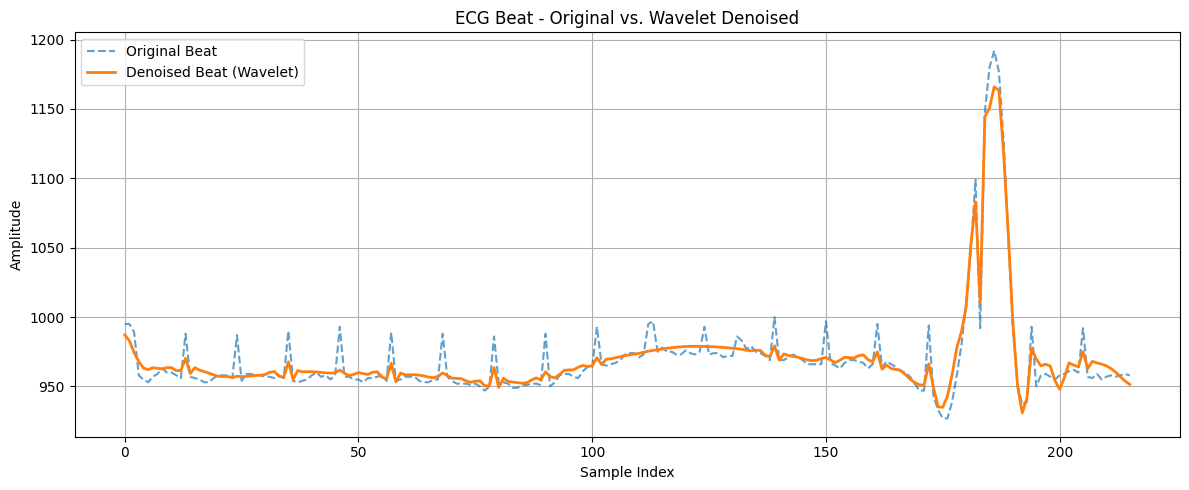

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import pywt
import numpy as np

# Load merged labeled beats
df = pd.read_csv("merged_labeled_beats.csv")

# Pick a single beat to visualize (e.g., first one)
beat_columns = df.columns.difference(['Label', 'Record'])
original_beat = df.loc[0, beat_columns].values

# --- Wavelet Denoising Function ---
def wavelet_denoise(signal, wavelet='db6', level=4, threshold_method='soft'):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    denoised_coeffs = [coeffs[0]]  # Keep approximation coefficients untouched
    for detail in coeffs[1:]:
        denoised_coeffs.append(pywt.threshold(detail, uthresh, mode=threshold_method))
    denoised = pywt.waverec(denoised_coeffs, wavelet)
    return denoised[:len(signal)]  # Ensure same length

# Denoise the beat
denoised_beat = wavelet_denoise(original_beat)

# --- Plotting ---
plt.figure(figsize=(12, 5))
plt.plot(original_beat, label='Original Beat', alpha=0.7, linestyle='--')
plt.plot(denoised_beat, label='Denoised Beat (Wavelet)', linewidth=2)
plt.title("ECG Beat - Original vs. Wavelet Denoised")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Low-pass filtering

In [13]:
from scipy.signal import butter, filtfilt

def lowpass_filter(signal, cutoff=45, fs=360, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

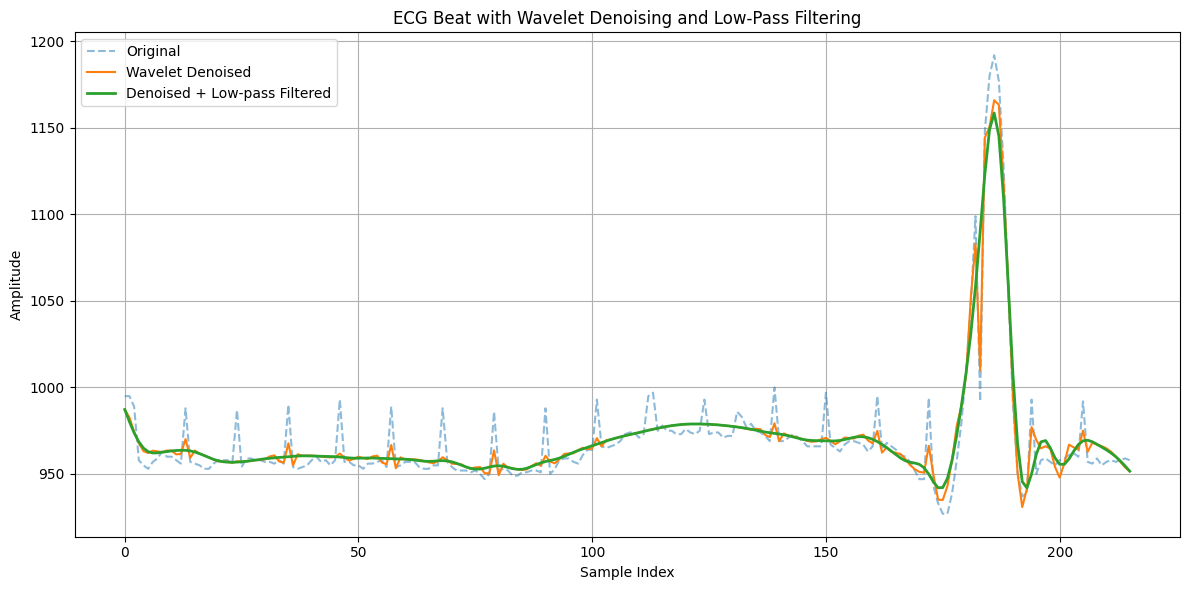

In [14]:
# Apply both wavelet denoising and then low-pass filter
denoised = wavelet_denoise(original_beat)
filtered = lowpass_filter(denoised)

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(original_beat, label='Original', linestyle='--', alpha=0.5)
plt.plot(denoised, label='Wavelet Denoised', linewidth=1.5)
plt.plot(filtered, label='Denoised + Low-pass Filtered', linewidth=2)
plt.title("ECG Beat with Wavelet Denoising and Low-Pass Filtering")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Z-score normalization (Standardization)

In [15]:
def z_score_normalize(signal):
    return (signal - np.mean(signal)) / np.std(signal)

Min-Max normalization

In [16]:
def min_max_normalize(signal):
    return (signal - np.min(signal)) / (np.max(signal) - np.min(signal))

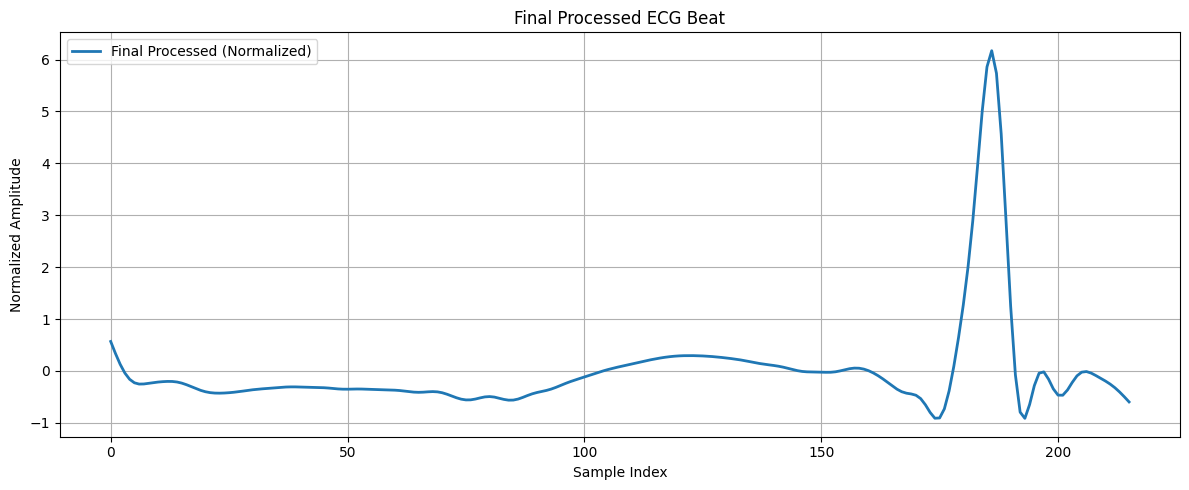

In [17]:
# Full processing: denoise → filter → normalize
processed = wavelet_denoise(original_beat)
processed = lowpass_filter(processed)
normalized = z_score_normalize(processed)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(normalized, label='Final Processed (Normalized)', linewidth=2)
plt.title("Final Processed ECG Beat")
plt.xlabel("Sample Index")
plt.ylabel("Normalized Amplitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Feature Extraction

In [18]:
import numpy as np
from scipy.stats import skew, kurtosis  # Add these imports
from numpy.fft import fft  # Add this import

def extract_features(signal, fs=360):
    features = {
        "mean": np.mean(signal),
        "std": np.std(signal),
        "max": np.max(signal),
        "min": np.min(signal),
        "ptp": np.ptp(signal),
        "skew": skew(signal),
        "kurtosis": kurtosis(signal),
        "energy": np.sum(np.square(signal)),
    }
    freqs = np.abs(fft(signal))
    freqs = freqs[:len(freqs)//2]
    norm_freqs = freqs / np.sum(freqs + 1e-8)
    features["spectral_entropy"] = -np.sum(norm_freqs * np.log(norm_freqs + 1e-8))
    features["dominant_freq"] = np.argmax(freqs) * (fs / len(signal))
    return features

# === 2. Load beat data ===

df = pd.read_csv("denoised_labeled_beats.csv")  # or "merged_labeled_beats.csv" if raw
beat_columns = df.columns.difference(['Label', 'Record'])

# === 3. Process all beats and extract features ===

feature_list = []

for idx, row in df.iterrows():
    signal = row[beat_columns].values.astype(float)

    # Feature extraction
    features = extract_features(signal)
    features["Label"] = row["Label"]
    features["Record"] = row["Record"]
    feature_list.append(features)

# === 4. Save to CSV ===

df_features = pd.DataFrame(feature_list)
df_features.to_csv("ecg_features.csv", index=False)
print("Feature extraction complete. Saved to ecg_features.csv")

Feature extraction complete. Saved to ecg_features.csv


Train Test Split

In [19]:
from sklearn.model_selection import train_test_split

X = df_features.drop(columns=["Label", "Record"])
y = df_features["Label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

Check and Clean Data

In [20]:
import pandas as pd

print("NaNs in X_train:\n", X_train.isna().sum())
print("Total rows with NaNs:", X_train.isna().any(axis=1).sum())

NaNs in X_train:
 mean                1
std                 1
max                 1
min                 1
ptp                 1
skew                1
kurtosis            1
energy              1
spectral_entropy    1
dominant_freq       0
dtype: int64
Total rows with NaNs: 1


In [21]:
X_train_clean = X_train.fillna(X_train.mean())
y_train_clean = y_train  # No change needed

Train Gaussian Mixture Model

In [22]:
from sklearn.mixture import GaussianMixture
gmms = {}
classes = np.unique(y_train_clean)

for cls in classes:
    gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
    gmm.fit(X_train_clean[y_train_clean == cls])
    gmms[cls] = gmm

In [23]:
def predict_gmm(gmms, X):
    classes = list(gmms.keys())
    scores = np.vstack([gmms[cls].score_samples(X) for cls in classes]).T  # Shape: [n_samples, n_classes]
    pred_indices = np.argmax(scores, axis=1)
    return [classes[i] for i in pred_indices]

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = predict_gmm(gmms, X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           "       0.95      0.97      0.96        87
           A       0.18      0.61      0.28       509
           E       0.59      0.95      0.73        21
           F       0.14      0.73      0.23       160
           J       0.01      0.65      0.02        17
           L       0.61      0.78      0.68      1615
           N       0.98      0.52      0.68     14954
           Q       0.00      0.00      0.00         3
           R       0.74      0.85      0.79      1451
           V       0.78      0.80      0.79      1425
           a       0.03      0.73      0.06        30
           e       0.00      0.33      0.01         3
           f       0.13      0.73      0.22        52
           j       0.02      0.80      0.04        46

    accuracy                           0.59     20373
   macro avg       0.37      0.67      0.39     20373
weighted avg       0.88      0.59      0.68     20373

[[  84    0    0    0    

d:\FYP 1\FYP 2\shap-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\FYP 1\FYP 2\shap-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\FYP 1\FYP 2\shap-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


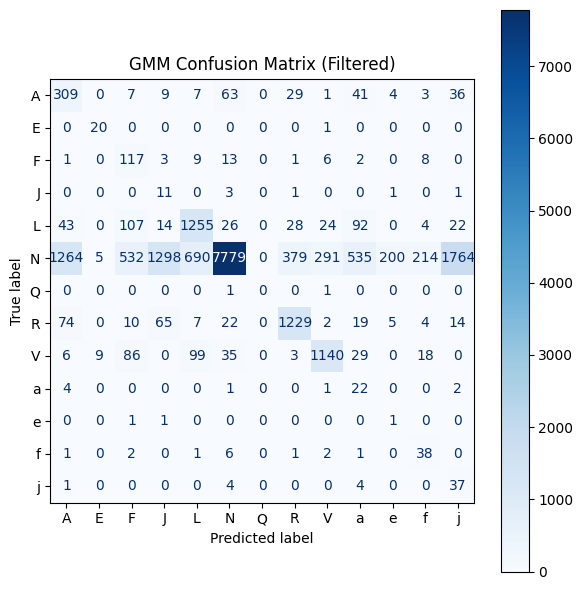

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert to NumPy arrays
y_test = np.array(y_test)
y_pred = np.array(y_pred)

# Filter out entries with label '"'
filtered_indices = (y_test != '"') & (y_pred != '"')
y_test_filtered = y_test[filtered_indices]
y_pred_filtered = y_pred[filtered_indices]

# Create confusion matrix with filtered data
labels = np.unique(y_test_filtered)
cm = confusion_matrix(y_test_filtered, y_pred_filtered, labels=labels)

# Plot confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, cmap="Blues", values_format='d')
ax.set_title("GMM Confusion Matrix (Filtered)")
plt.tight_layout()
plt.show()

Implement XAI
First step: analyze feature

In [26]:
# Assume you have X_train and y_train already split
X_train_df = pd.DataFrame(X_train)
X_train_df['Label'] = y_train

# Group by label and compute mean and std
feature_means = X_train_df.groupby('Label').mean()
feature_stds = X_train_df.groupby('Label').std()

print("Feature means and std calculated!")

Feature means and std calculated!


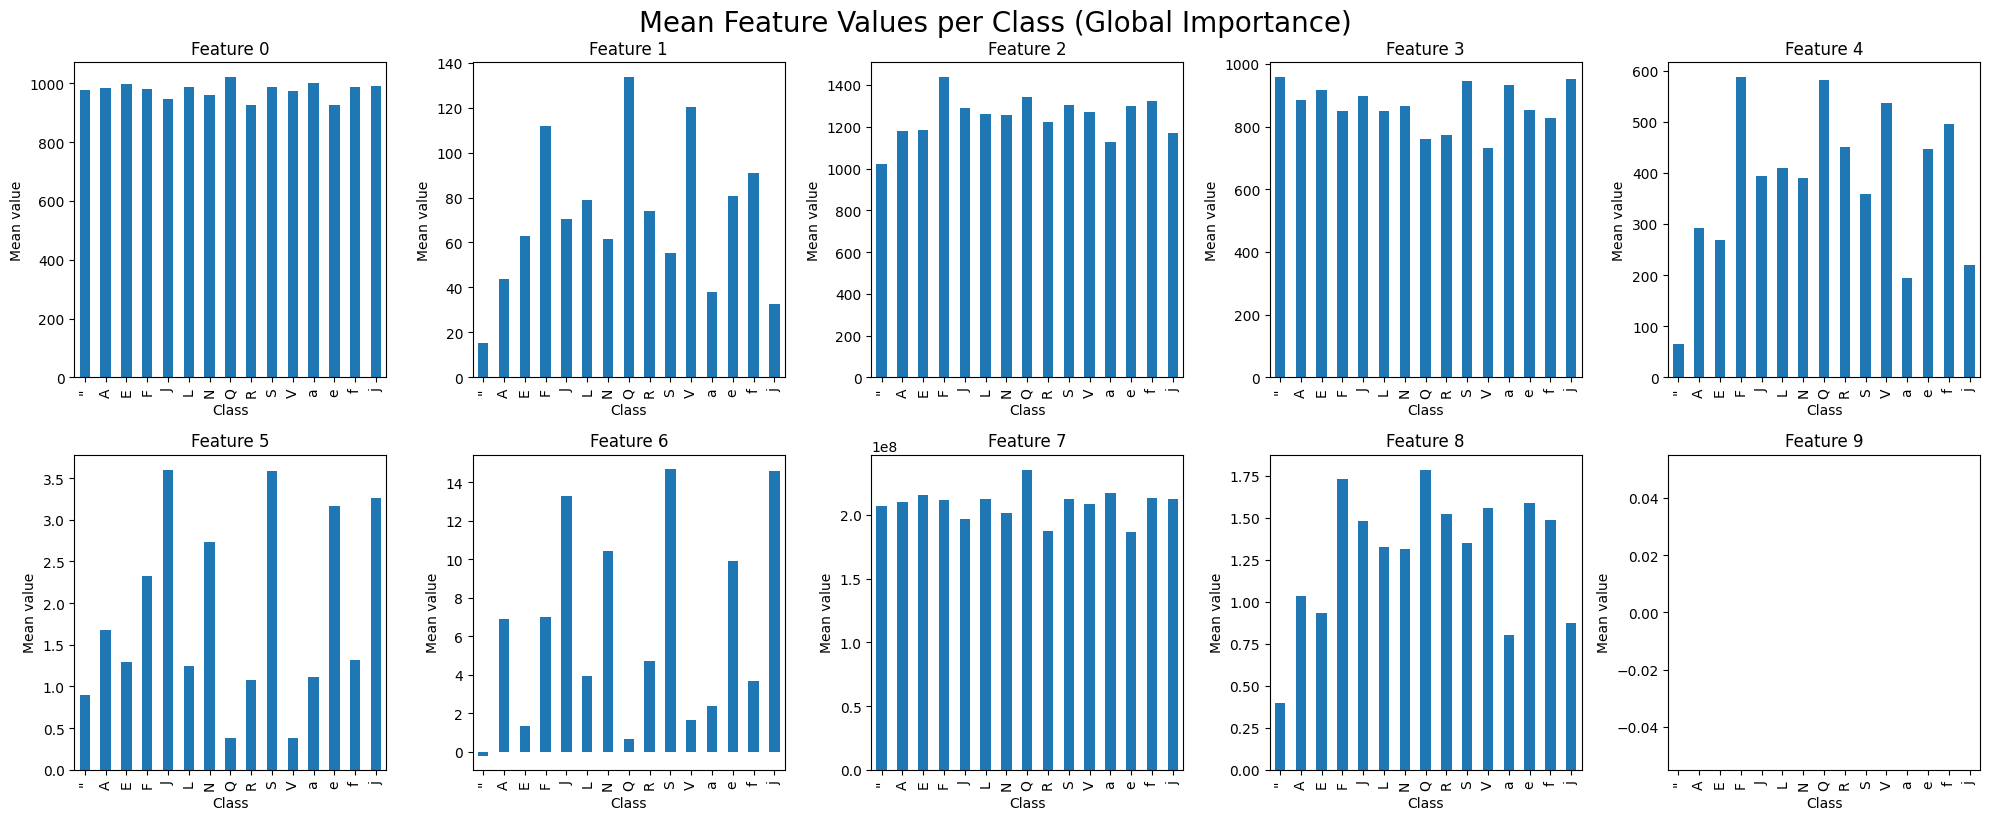

In [27]:
import math

n_features = feature_means.shape[1]
n_cols = 5
n_rows = math.ceil(n_features / n_cols)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axs = axs.flatten()

for i in range(n_features):
    ax = axs[i]
    feature_means.iloc[:, i].plot(kind='bar', ax=ax, title=f"Feature {i}")
    ax.set_ylabel("Mean value")
    ax.set_xlabel("Class")

# Remove unused subplots
for i in range(n_features, len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.suptitle("Mean Feature Values per Class (Global Importance)", y=1.02, fontsize=20)
plt.show()


In [28]:
# Step 1: Calculate standard deviation across classes for each feature
feature_separation_strength = feature_means.std(axis=0)

# Step 2: Rank features (higher std = more important)
ranked_features = feature_separation_strength.sort_values(ascending=False)

# Step 3: Display Top N Features
top_n = 10
print(f"Top {top_n} Features Ranked by Class Separation Strength:\n")
for idx, (feature_idx, importance) in enumerate(ranked_features.items()):
    print(f"Rank {idx+1}: Feature {feature_idx} (Separation Score = {importance:.4f})")
    if idx+1 == top_n:
        break

Top 10 Features Ranked by Class Separation Strength:

Rank 1: Feature energy (Separation Score = 12137288.4960)
Rank 2: Feature ptp (Separation Score = 149.2287)
Rank 3: Feature max (Separation Score = 99.7028)
Rank 4: Feature min (Separation Score = 71.0052)
Rank 5: Feature std (Separation Score = 33.0971)
Rank 6: Feature mean (Separation Score = 26.9594)
Rank 7: Feature kurtosis (Separation Score = 5.1371)
Rank 8: Feature skew (Separation Score = 1.1376)
Rank 9: Feature spectral_entropy (Separation Score = 0.3904)
Rank 10: Feature dominant_freq (Separation Score = 0.0000)


Apply XAI Model (SHAP)

In [29]:
!pip install shap

In [30]:
# Clean X before using it
X_clean = X.fillna(X.mean())

# Now safely predict cluster labels using any GMM (e.g., one from the trained dict or one generic)
gmm_labels = gmms[classes[0]].predict(X_clean)  # Pick any one GMM (for SHAP surrogate target)

d:\FYP 1\FYP 2\shap-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|===================| 203716/203724 [225:06<00:00]         

<Figure size 640x480 with 0 Axes>

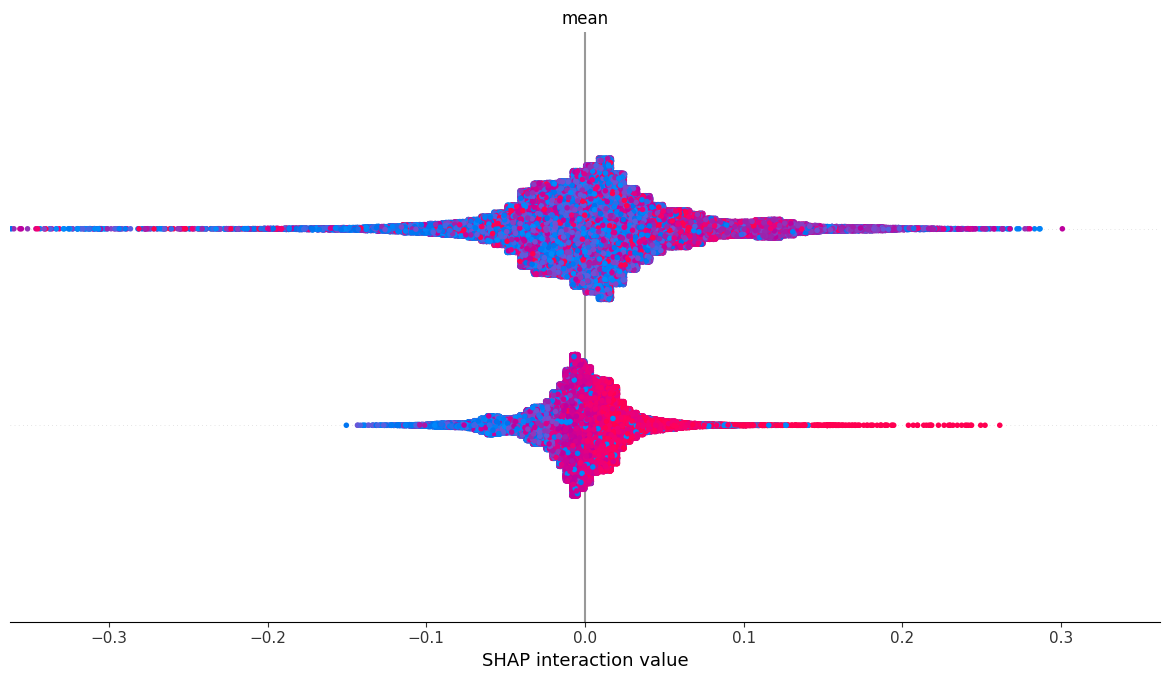

In [31]:
from sklearn.ensemble import RandomForestClassifier
import shap

# Train a surrogate Random Forest to mimic the GMM clusters
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_clean, gmm_labels)

# Use SHAP to explain what features influence GMM-style clustering
explainer = shap.Explainer(clf, X_clean)
shap_values = explainer(X_clean)
shap.summary_plot(shap_values, X_clean)